In [75]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.2.0
2.2.0


In [76]:
from pathlib import Path
from glob import glob
path = Path() / "Guitar Dataset"
data_path = glob(f"{path}/**/*.wav")

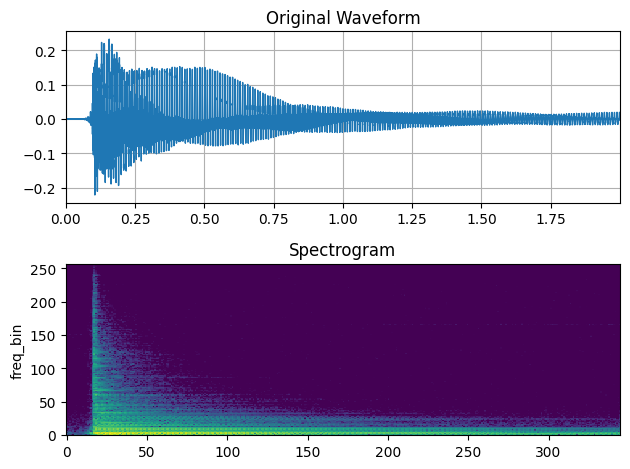

In [77]:
from utils import plot_spectrogram, plot_waveform
import torchaudio.transforms as T

sample_path = data_path[0]

## Load Audio
waveform, sample_rate = torchaudio.load(sample_path)

## Define transform
spectrogram = T.Spectrogram(n_fft=512)

## Perform transform
spec = spectrogram(waveform) #( batch, num_channel, time_axis )

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original Waveform", ax=axs[0])
plot_spectrogram(spec[0], title="Spectrogram", ax=axs[1])
fig.tight_layout()

In [78]:
from IPython.display import Audio

Audio(waveform.numpy(), rate=sample_rate)

In [79]:
spec.shape

torch.Size([1, 257, 345])

In [80]:
from pprint import pprint
pprint(spec)

tensor([[[1.0330e-03, 2.3102e-04, 5.0018e-04,  ..., 4.0620e-01,
          3.2387e-02, 1.5002e+00],
         [2.8875e-03, 9.0742e-05, 7.2548e-04,  ..., 2.1680e+00,
          2.8975e+00, 2.3270e+00],
         [3.1227e-03, 5.1559e-04, 8.6940e-04,  ..., 3.9830e-01,
          3.0788e+00, 7.6311e-01],
         ...,
         [8.3308e-09, 3.2651e-07, 7.0228e-08,  ..., 5.7541e-08,
          1.1461e-08, 8.4992e-08],
         [1.8116e-09, 8.1420e-08, 2.2164e-08,  ..., 1.6052e-08,
          5.6932e-09, 3.6085e-08],
         [4.9281e-08, 8.6432e-08, 4.7568e-08,  ..., 1.2832e-09,
          1.3214e-09, 2.7512e-11]]])


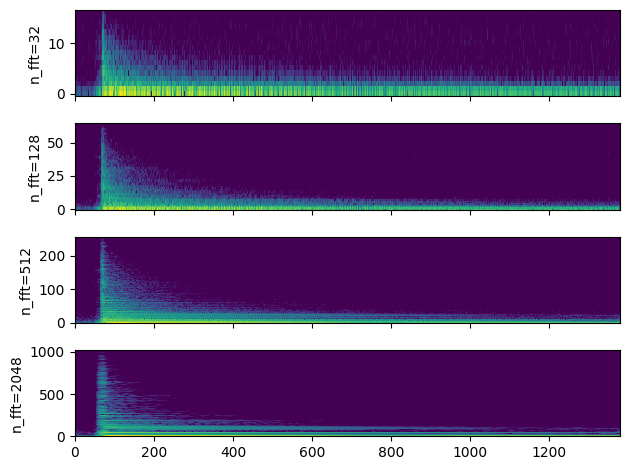

In [81]:
## n_fft 는 주파수의 해상도를 결정 ( 값이 높으면 해상도가 높아도 시각화했을 때는 흐리게 보일 수 있음 ) *
## hop_length 는 시간의 해상도를 결정
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(waveform)
    specs.append(spec)

fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

In [82]:
## Down Sampling sample_rate 가 낮으면 낮을수록 소리의 해상도가 떨어짐 ( 먹먹하게 들림 물 속에서 노래 듣는 것 처럼 )
import torchaudio
from IPython.display import Audio

downsample_waveform = torchaudio.functional.resample(waveform, sample_rate, sample_rate // 10)
Audio(downsample_waveform.numpy(), rate=sample_rate // 10)

In [83]:
import torchaudio
from IPython.display import Audio

upsample_waveform = torchaudio.functional.resample(downsample_waveform, sample_rate // 10, sample_rate)
Audio(upsample_waveform.numpy(), rate=sample_rate)

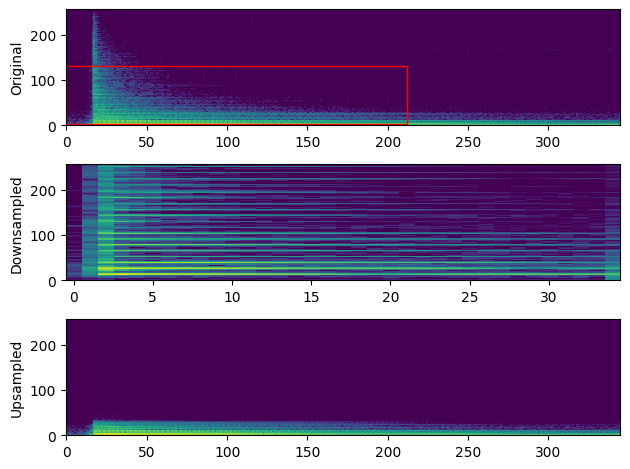

In [84]:
## 다운 샘플링을 했다가 업샘플링을 하면 스펙토그램이 더 명확해진다네요
import torchaudio.transforms as T
from matplotlib.patches import Rectangle

spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(waveform)
spec1 = spectrogram(downsample_waveform)
spec2 = spectrogram(upsample_waveform)

fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0,3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec1[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec2[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

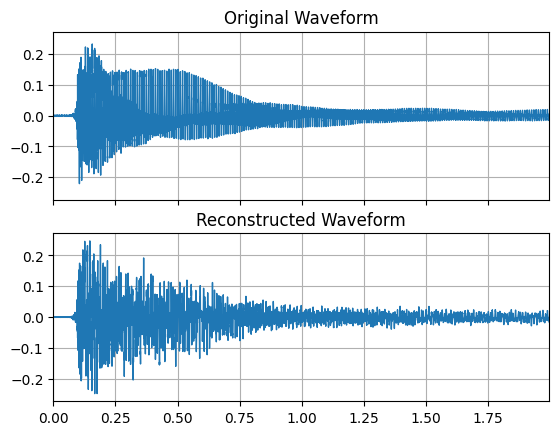

In [85]:
## 파형 복구
import torchaudio.transforms as T
import matplotlib.pyplot as plt

## Define transforms
n_fft = 512
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

## Apply the transforms
spec = spectrogram(waveform)
reconstructed_waveform = griffin_lim(spec)

_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(waveform, sample_rate, title="Original Waveform", ax=axes[0])
plot_waveform(reconstructed_waveform, sample_rate, title="Reconstructed Waveform", ax=axes[1])
Audio(reconstructed_waveform.numpy(), rate=sample_rate)

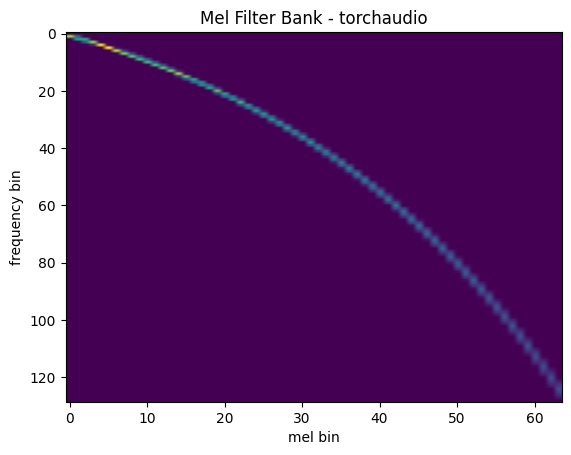

In [86]:
## Mel Bank With torchaudio
import torchaudio.functional as F
from utils import plot_fbank

n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

Mean Square Difference:  3.934872696751886e-17


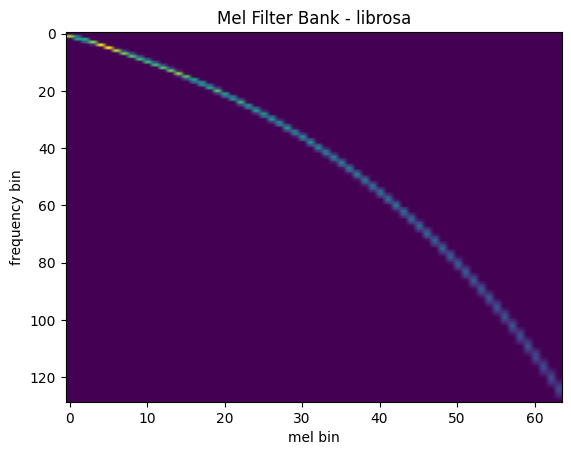

In [87]:
## Mel Bank With librosa
import librosa
import torch

mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

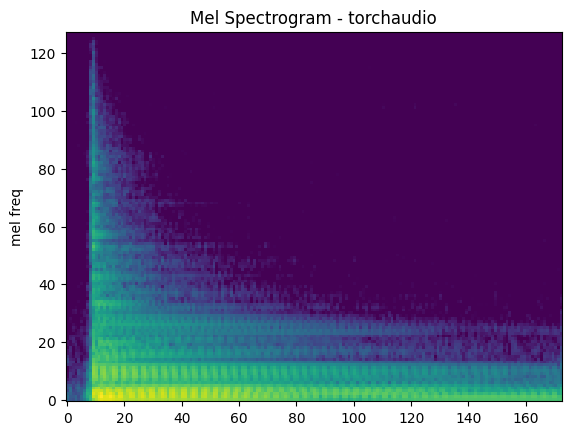

In [88]:
## MelSpectrogram
import torchaudio.transforms as T

n_fft = 1024
win_length = 512
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk"
)
melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], title="Mel Spectrogram - torchaudio", ylabel="mel freq")

In [94]:
import torchaudio.functional as F
from utils import plot_pitch

pitch = F.detect_pitch_frequency(waveform, sample_rate)

plot_pitch(waveform, sample_rate, pitch)

ImportError: cannot import name 'plot_pitch' from 'utils' (/mnt/d/PycharmProjects/PytorchBook/audio/utils.py)